# <center>Site-level Study on Pollution Outcomes with Policy Effects:</center>
## <center>Data Pipeline</center>

## Overview of Datasets

| Dataset | Temporal Resolution | Role | Notes / Links |
|---|---|---|---|
| **EEA Industrial Emissions Portal – LCP** | Annual (wide) | **EU** large-combustion plant attributes & coordinates | EU plant universe. Provides yearly `capacity_mw` and `fuel_shares`. [EEA LCP](https://industry.eea.europa.eu/explore/explore-lcp) |
| **EU Registry on Industrial Sites** | Annual | LCP ↔ ETS installation linkage | Official crosswalk from EEA. Downloaded from [EEA SDI Catalogue](https://sdi.eea.europa.eu/catalogue/srv/eng/catalog.search#/meta21e758c6-a9ac-4a7d-a64a-19d2ba9eecb7). Extracted `ETSIdentifiers.csv` and `ProductionInstallationPart.csv` from AccessDB file using [mdbtools](https://github.com/brianb/mdbtools). |
| **EU ETS (pyeutl)** | First compliance year → **yearly** | Installation-level emissions & allowances | Loaded from **EUETS.INFO extracts** via `pyeutl.ziploader`. Linked to LCP via normalized ETS identifiers from above. |
| **TROPOMI NO₂ (S5P)** | Daily → yearly | Outcome variable | Tropospheric NO₂ column density processed via **Beirle-style flux divergence method**: advection-based emission quantification with lifetime correction and NO₂→NOx scaling. Reference: Beirle et al. (2023), ESSD 15. |
| **ERA5-Land Hourly** | Daily → yearly | Wind fields | Daily wind u/v components for advection computation; calm days (< 0.5 m/s) excluded. |
| **AlphaEarth Embeddings** | Annual | Geographic context | Google Satellite Embedding V1 for land use, infrastructure, climate controls. |

---

## Data Model

### Key Entities
- **Facility** = Physical combustion plant(s) grouped by 500m spatial proximity (`idx` = primary key)
- **EU ETS Installation** = Regulatory compliance unit (many-to-one relationship with LCP)

### Time-Varying vs Static Attributes
| Attribute Type | Examples | Panel Structure |
|---|---|---|
| **Static** | Coordinates, country, plant names, ETS / LCP identifiers | One row per facility |
| **Time-Varying** | Capacity (MW), fuel shares, ETS emissions, satellite NOx emissions, embeddings | Plant × year panel |

---

## Outputs

This notebook produces **three main output files**:

#### 1. `out/facilities_static.parquet` — Static Attributes
One row per facility with time-invariant characteristics:

| Column | Description |
|---|---|
| `idx` | Facility identifier (primary key) |
| `lat`, `lon` | Coordinates (centroid of clustered plants) |
| `country_code` | ISO-2 country code |
| `name` | Plant name(s) |
| `LCPInspireId` | LCP INSPIRE identifier(s) |
| `ets_id` | EU ETS installation identifier(s) |

#### 2. `out/facilities_yearly.parquet` — Time-Varying Panel
Plant × year panel with all time-varying covariates:

| Column Group | Columns | Source |
|---|---|---|
| **Keys** | `idx`, `year` | — |
| **Capacity** | `capacity_mw` | LCP (yearly) |
| **Fuel Mix** | `share_gas`, `share_coal`, `share_oil`, `share_biomass`, ... | LCP (yearly) |
| **ETS Exposure** | `eu_verified_tco2`, `eu_alloc_total_tco2`, `eu_shortfall_tco2`, `eu_alloc_ratio`, `n_installations` | EU ETS |
| **Meteorology** | `mean_ws_ms`, `n_days_satellite` | ERA5-Land |
| **Geographic Context** | `emb_{band}` (64 dimensions) | AlphaEarth |

#### 3. `out/beirle_panel.parquet` — Satellite NOx Emission Estimates
Facility × year panel with Beirle-style NOx emission estimates (filtered to ≥0.03 kg/s detection limit):

| Column | Description |
|---|---|
| `idx`, `year` | Keys |
| `beirle_nox_kg_s` | NOx emission rate [kg/s] |
| `beirle_nox_kg_s_se` | Statistical standard error [kg/s] |
| `rel_err_total` | Combined relative uncertainty |
| `n_days_satellite` | Number of valid satellite days |

In [ ]:
import pandas as pd 
from pandas import DataFrame
import numpy as np
import re
import os
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree # type: ignore

In [ ]:
START_YEAR = 2018
END_YEAR = 2023
MIN_YEARS = 3
FAC_ID_COL = 'idx'
LCP_ETS_DIR = "LCP_ETS_DATA"
LCP_PATH = f"{LCP_ETS_DIR}/EEA_Industry_Dataset_LCP.xlsx"
INSTALL_PART_PATH = f"{LCP_ETS_DIR}/ProductionInstallationPart.csv"
ETS_ID_PATH       = f"{LCP_ETS_DIR}/ETSIdentifiers.csv"
EUETS_ZIP = "eutl_2024_202410/eutl_2024_202410.zip"
os.makedirs("out", exist_ok=True)

## 1. LCP Facilities
### Load, Clean and Aggregate EEA Large Combustion Plants (LCP) data to get facilities + yearly attributes panel
#### Filters
- **Year**: We filter to the years 2018-2023.
- **Fuels**: We filter out fuels used by less than 10% of facilities and remove facitlities with no
  other fuels.

### Helpers

In [ ]:
from processing import fuel_group_map

### Ingest LCP Data

In [ ]:
plants = pd.read_excel(LCP_PATH, sheet_name="LCP_Energy_Emissions", dtype={"LCPInspireId": str})

year_cols = [
    c for c in plants.columns
    if re.fullmatch(r"\d{4}", str(c)) and int(START_YEAR) <= int(c) <= int(END_YEAR)
]

# ISO-2 from 'AT.CAED/...' prefix
plants["country_code"] = plants["LCPInspireId"].str.split(".").str[0].str.upper()

# Drop rows where country_code starts with "HTTP"
plants = plants[~plants["country_code"].str.startswith("HTTP", na=False)] 

print(f"Loaded {plants['LCPInspireId'].nunique():,} unique LCP plants from {LCP_PATH}") # type: ignore

Loaded 3,405 unique LCP plants from data/LCP_ETS_DATA/EEA_Industry_Dataset_LCP.xlsx


### Gather Plant Level Time-Varying Data

#### Yearly Capacity

In [ ]:
cap_rows = plants[
    (plants["featureType"] == "LCPCharacteristics") &
    (plants["unit"].astype(str).str.upper() == "MW") # type: ignore
].copy()

# Melt year columns to long format for yearly capacity
cap_long = cap_rows.melt( # type: ignore
    id_vars=["LCPInspireId"],
    value_vars=year_cols,
    var_name="year",
    value_name="capacity_mw"
)
cap_long["year"] = cap_long["year"].astype(int)
cap_long["capacity_mw"] = pd.to_numeric(cap_long["capacity_mw"], errors="coerce").fillna(0) # type: ignore

# Aggregate capacity by plant × year (sum if multiple rows per plant)
capacity_yearly = (
    cap_long.groupby(["LCPInspireId", "year"], as_index=False)
    .agg(capacity_mw=("capacity_mw", "sum"))
)

# Drop plant-years with capacity = 0
capacity_yearly = capacity_yearly[capacity_yearly["capacity_mw"] > 0]

print(f"Built yearly capacity panel: {len(capacity_yearly):,} rows, "
      f"{capacity_yearly['LCPInspireId'].nunique():,} plants") # type: ignore

Built yearly capacity panel: 14,653 rows, 2,983 plants


In [ ]:
capacity_yearly.sample(5) # type: ignore

,LCPInspireId,year,capacity_mw
13825,PL.MŚ/000000036.PART,2019,191.490
1638,CZ.CHMI.0051/CZ0051.PART,2018,1264.974
11010,IT.CAED/980571001.PART,2018,1076.000
9628,IT.CAED/301761009.PART,2022,58.140
17502,SE.CAED/10000029.Part,2018,1122.000


#### Yearly Fuel Energy Usage

In [ ]:
# =============================================================================
# Build yearly fuel ENERGY panel (plant × year × fuel_group) in TJ
# Keep raw TJ values - shares will be computed AFTER facility-level aggregation
# =============================================================================
FUEL_FEATURES = [
    "Coal","Lignite","OtherSolidFuels","NaturalGas","LiquidFuels",
    "OtherGases","Peat","Biomass"
]
fuel_rows = plants[
    plants["featureType"].isin(FUEL_FEATURES) &  # type: ignore
    (plants["unit"].astype(str).str.upper() == "TJ")  # type: ignore
].copy()

fuel_energy_yearly = DataFrame()  # plant × year panel with fuel energy (TJ)

fuel_rows["fuel_group"] = fuel_rows["featureType"].apply(fuel_group_map) # type: ignore

# Melt year columns to long format: one row per (plant, fuel_group, year)
fuel_long = fuel_rows.melt( # type: ignore
    id_vars=["LCPInspireId", "fuel_group"],
    value_vars=year_cols,
    var_name="year",
    value_name="energy_tj"
) # type: ignore
fuel_long["year"] = fuel_long["year"].astype(int)
fuel_long["energy_tj"] = pd.to_numeric(fuel_long["energy_tj"], errors="coerce").fillna(0) # type: ignore

# Sum energy by plant × year × fuel_group (in case multiple rows per combination)
fuel_agg = (
    fuel_long.groupby(["LCPInspireId", "year", "fuel_group"], as_index=False)
    .agg(energy_tj=("energy_tj", "sum"))
)

# Pivot to wide format: one column per fuel_group (TJ values, not shares)
fuel_energy_yearly = fuel_agg.pivot_table(
    index=["LCPInspireId", "year"],
    columns="fuel_group",
    values="energy_tj",
    fill_value=0
).reset_index()

# Prefix columns for clarity (energy in TJ)
fuel_cols = [c for c in fuel_energy_yearly.columns if c not in ["LCPInspireId", "year"]]
fuel_energy_yearly = fuel_energy_yearly.rename(
    columns={c: f"energy_tj_{c.lower().replace(' ', '_').replace('/', '_')}" for c in fuel_cols}
)

# Drop rows where all fuel energy values are 0
energy_cols = [c for c in fuel_energy_yearly.columns if c.startswith("energy_tj_")]
fuel_energy_yearly = fuel_energy_yearly[fuel_energy_yearly[energy_cols].sum(axis=1) > 0]

print(f"Built yearly fuel energy panel: {len(fuel_energy_yearly):,} rows, "
        f"{fuel_energy_yearly['LCPInspireId'].nunique():,} plants, " # type: ignore
        f"{fuel_energy_yearly['year'].nunique()} years") # type: ignore

Built yearly fuel energy panel: 13,413 rows, 2,826 plants, 6 years


#### Merge and Filter

In [ ]:
# Merge capacity and fuel energy into single LCP yearly panel
plants_yearly = capacity_yearly.merge(fuel_energy_yearly, on=["LCPInspireId", "year"], how="inner") # type: ignore

# Filter Years
plants_yearly = plants_yearly[plants_yearly["year"] >= START_YEAR]
plants_yearly = plants_yearly[plants_yearly["year"] <= END_YEAR]

print(f"Combined LCP yearly panel for {START_YEAR} to {END_YEAR}: {len(plants_yearly):,} rows")

Combined LCP yearly panel for 2018 to 2023: 13,386 rows


### Build static plant attributes 

In [ ]:
# =============================================================================
# Build static plant attributes with ETS linking
# =============================================================================
plants_static = (
    cap_rows.assign( # type: ignore
        capacity_mw_min=cap_rows[year_cols].replace(0, np.nan).min(axis=1, skipna=True)  # type: ignore 
    )
    .groupby("LCPInspireId", as_index=False)
    .agg(
        name=("installationPartName", "first"),
        lon=("Longitude", "first"),
        lat=("Latitude", "first"),
        country_code=("country_code", "first"),
    )
)

# Filter to plants that have complete data in plants_yearly (after inner join)
valid_lcp_ids = set(plants_yearly["LCPInspireId"].unique()) # type: ignore
n_before = len(plants_static)
plants_static = plants_static[plants_static["LCPInspireId"].isin(valid_lcp_ids)] # type: ignore
print(f"Filtered to {len(plants_static):,} plants with complete LCP data (dropped {n_before - len(plants_static):,})")

# ------------------------------------------------------------------
# Link LCP parts to ETS installation IDs Using EU Registry on Industrial Sites
# ------------------------------------------------------------------

# ProductionInstallationPart.csv: LCP part -> parent installation
ipp = pd.read_csv(
    INSTALL_PART_PATH,
    dtype={
        "Installation_Part_INSPIRE_ID": str,
        "Parent_Installation_INSPIRE_ID": str
    }
)

lcp_install = (
    ipp[["Installation_Part_INSPIRE_ID", "Parent_Installation_INSPIRE_ID"]]
    .drop_duplicates()
    .rename(columns={"Installation_Part_INSPIRE_ID": "LCPInspireId"}) # type: ignore
) 

# ETSIdentifiers.csv: installation -> ETSIdentifier (+ reporting year)
ets = pd.read_csv(ETS_ID_PATH, dtype={"Installation_INSPIRE_ID": str})

# If ReportingYear exists, restrict to desired window and keep latest in window
if "ReportingYear" in ets.columns:
    ets["ReportingYear"] = pd.to_numeric(ets["ReportingYear"], errors="coerce")
    ets = ets[
        (ets["ReportingYear"] >= int(START_YEAR)) &
        (ets["ReportingYear"] <= int(END_YEAR))
    ]
    ets = (
        ets.sort_values(["Installation_INSPIRE_ID", "ReportingYear"]) # type: ignore
           .drop_duplicates("Installation_INSPIRE_ID", keep="last")
    )

# Merge LCP -> installation
plants_static = plants_static.merge( # type: ignore
    lcp_install,
    on="LCPInspireId",
    how="left"
)

# Merge installation -> ETSIdentifier
plants_static = plants_static.merge(
    ets[["Installation_INSPIRE_ID", "ETSIdentifier"]],
    left_on="Parent_Installation_INSPIRE_ID",
    right_on="Installation_INSPIRE_ID",
    how="left"
)

plants_static = plants_static.drop(columns=["Parent_Installation_INSPIRE_ID", "Installation_INSPIRE_ID"], errors="ignore")

# Aggregate ETS IDs into list per LCPInspireId (1 LCP can have multiple ETS installations)
n_before_agg = len(plants_static)
plants_static = (
    plants_static.groupby("LCPInspireId", as_index=False)
    .agg({
        "name": "first",
        "lon": "first",
        "lat": "first",
        "country_code": "first",
        "ETSIdentifier": lambda x: list(x.dropna().unique())  # collect all ETS IDs
    })
    .rename(columns={"ETSIdentifier": "ets_id"}) 
) # type: ignore

n_with_ets = (plants_static["ets_id"].apply(len) > 0).sum()
print(f"Aggregated ETS IDs: {n_before_agg:,} → {len(plants_static):,} rows | {n_with_ets:,} plants have ≥1 ETS ID")

# ------------------------------------------------------------------
# Drop plants without any ETS IDs from both plants_static and plants_yearly
# ------------------------------------------------------------------
n_before_ets = len(plants_static)
plants_static = plants_static[plants_static["ets_id"].apply(len) > 0]
plants_with_ets = set(plants_static["LCPInspireId"].unique()) # type: ignore

plants_yearly = plants_yearly[plants_yearly["LCPInspireId"].isin(plants_with_ets)] # type: ignore

print(f"Dropped {n_before_ets - len(plants_static):,} plants without ETS IDs")
print(f"Final: plants_static has {len(plants_static):,} plants | plants_yearly has {len(plants_yearly):,} rows ({plants_yearly['LCPInspireId'].nunique():,} plants for years {plants_yearly['year'].min()}-{plants_yearly['year'].max()})") # type: ignore

# Drop Plants from plants_static that are not in plants_yearly
plants_static = plants_static[plants_static["LCPInspireId"].isin(plants_yearly["LCPInspireId"])] # type: ignore

# Sanity check
assert len(plants_static) == plants_yearly["LCPInspireId"].nunique(), "Mismatch between plants_static and plants_yearly!" # type: ignore

Filtered to 2,821 plants with complete LCP data (dropped 584)
Aggregated ETS IDs: 9,175 → 2,821 rows | 1,580 plants have ≥1 ETS ID
Dropped 1,241 plants without ETS IDs
Final: plants_static has 1,580 plants | plants_yearly has 7,413 rows (1,580 plants for years 2018-2023)


### Aggregate plants to Facility level

In [ ]:
# Filter plants_static to valid coordinates
fac_base = plants_static.dropna(subset=["lat", "lon"]).copy() # type: ignore
fac_base["lat"] = pd.to_numeric(fac_base["lat"].astype(str).str.strip(), errors="coerce")
fac_base["lon"] = pd.to_numeric(fac_base["lon"].astype(str).str.strip(), errors="coerce")
fac_base = fac_base[(fac_base["lat"] != 0) & (fac_base["lon"] != 0)]
fac_base = fac_base[~fac_base["country_code"].str.startswith("HTTP", na=False)] # type: ignore
fac_base = fac_base.reset_index(drop=True) # type: ignore

# =============================================================================
# Fuzzy spatial clustering (500m threshold) using Union-Find
# Plants within 500m are grouped into the same facility
# =============================================================================
FUZZY_THRESHOLD_M = 500

# =============================================================================
# Convert lat/lon to meters using WGS84 ellipsoid formulas
# Reference: Wikipedia "Latitude" - Meridian distance on the ellipsoid
# https://en.wikipedia.org/wiki/Latitude#Meridian_distance_on_the_ellipsoid
#
# For WGS84:
#   m/deg latitude  = 111132.954 - 559.822*cos(2*lat) + 1.175*cos(4*lat)
#   m/deg longitude = (pi * a * cos(lat)) / (180 * sqrt(1 - e^2 * sin^2(lat)))
#                   ≈ 111132.954 * cos(lat)  (simplified, <0.5% error)
# =============================================================================
lat_rad = np.radians(fac_base["lat"].values)  # type: ignore
mean_lat_rad = np.mean(lat_rad)

# Latitude: varies slightly with latitude (110.574 km at equator to 111.694 km at poles)
# Using the WGS84 series expansion (accurate to 0.01 m per Wikipedia)
m_per_deg_lat = 111132.954 - 559.822 * np.cos(2 * lat_rad) + 1.175 * np.cos(4 * lat_rad)

# Longitude: varies with cos(latitude)
# Using mean latitude for the dataset to compute a consistent scale factor
m_per_deg_lon = 111132.954 * np.cos(mean_lat_rad)

coords_m = np.column_stack([
    fac_base["lat"].values * m_per_deg_lat,  # type: ignore
    fac_base["lon"].values * m_per_deg_lon   # type: ignore
])

# Build spatial index and find pairs within threshold
tree = cKDTree(coords_m)
pairs = tree.query_pairs(r=FUZZY_THRESHOLD_M)

# Union-Find to build clusters
n_plants = len(fac_base)
parent = list(range(n_plants))

def find(x):
    if parent[x] != x:
        parent[x] = find(parent[x])
    return parent[x]

def union(x, y):
    parent[find(x)] = find(y)

for i, j in pairs:
    union(i, j)

# Assign cluster IDs
fac_base["cluster_id"] = [find(i) for i in range(n_plants)]

def agg_facility_static(g):
    """Aggregate to facility level - static attributes only."""
    # Flatten ets_id lists (each row's ets_id is already a list)
    all_ets_ids = []
    for ets_list in g["ets_id"]:
        if isinstance(ets_list, list):
            all_ets_ids.extend(ets_list)
    
    return pd.Series({
        "lat": g["lat"].mean(),  # centroid
        "lon": g["lon"].mean(),  # centroid
        "name": [f'"{n}"' for n in g["name"].dropna().tolist()],
        "country_code": g["country_code"].iloc[0],
        "LCPInspireId": list(g["LCPInspireId"].unique()),
        "ets_id": list(set(all_ets_ids))  # unique ETS IDs across all plants
    })

# Group plants by spatial cluster (500m fuzzy matching)
facilities_static = (
    fac_base.groupby("cluster_id")
    .apply(agg_facility_static, include_groups=False)
    .reset_index(drop=True)
)
facilities_static = facilities_static.dropna().reset_index(drop=True)
facilities_static[FAC_ID_COL] = facilities_static.index

# Report clustering stats
n_multi_plant = (fac_base.groupby("cluster_id").size() > 1).sum()
print(f"Built {len(facilities_static):,} facilities from {len(fac_base):,} plants "
      f"(500m fuzzy clustering, {n_multi_plant:,} multi-plant facilities)")

# =============================================================================
# Build facility-level yearly panel with fuel share aggregation
# =============================================================================

# Create mapping from LCPInspireId to facility idx
plants_to_fac = []
for _, row in facilities_static.iterrows():
    lcp_ids = row["LCPInspireId"]
    if isinstance(lcp_ids, list):
        for lcp_id in lcp_ids:
            plants_to_fac.append({"LCPInspireId": lcp_id, FAC_ID_COL: row[FAC_ID_COL]})
    else:
        plants_to_fac.append({"LCPInspireId": lcp_ids, FAC_ID_COL: row[FAC_ID_COL]})
plants_to_fac_df = DataFrame(plants_to_fac)

# Join LCP yearly panel to facility idx
facilities_yearly = plants_yearly.merge(plants_to_fac_df, on="LCPInspireId", how="inner") # type: ignore

# Identify energy columns (TJ values)
energy_cols = [c for c in facilities_yearly.columns if c.startswith("energy_tj_")]

# Aggregate at facility level: SUM capacity AND energy
agg_dict = {"capacity_mw": "sum"}
for ec in energy_cols:
    agg_dict[ec] = "sum"  # SUM energy across plants in same facility

facilities_yearly = (
    facilities_yearly.groupby([FAC_ID_COL, "year"], as_index=False)
    .agg(agg_dict)
)

Built 932 facilities from 1,576 plants (500m fuzzy clustering, 318 multi-plant facilities)


### Compute fuel shares from aggregated TJ values

In [ ]:
if energy_cols:
    # Total energy per facility-year
    total_energy = facilities_yearly[energy_cols].sum(axis=1)
    
    # Create share columns from energy columns
    share_cols = []
    for ec in energy_cols:
        share_col = ec.replace("energy_tj_", "share_")
        facilities_yearly[share_col] = ( # type: ignore
            facilities_yearly[ec] / total_energy.replace(0, np.nan)
        ).fillna(0)
        share_cols.append(share_col)
    
    # Drop raw energy columns (keep only shares)
    facilities_yearly = facilities_yearly.drop(columns=energy_cols) 
    
    print(f"Computed fuel shares from aggregated TJ: {share_cols}")

print(f"Built facility-level yearly panel: {len(facilities_yearly):,} rows, "
      f"{facilities_yearly[FAC_ID_COL].nunique():,} facilities") # type: ignore

Computed fuel shares from aggregated TJ: ['share_biomass', 'share_coal', 'share_gas', 'share_oil', 'share_other_gas', 'share_other_solid', 'share_peat']
Built facility-level yearly panel: 4,566 rows, 932 facilities


In [ ]:
share_stats = facilities_yearly[share_cols].describe().T[['mean', '50%', 'max']].round(3) # type: ignore
share_stats.columns = ['Mean', 'Median', 'Max']
share_stats['Fac-Yrs w/ >0'] = [(facilities_yearly[c] > 0).sum() for c in share_cols]
share_stats['% Fac-Yrs w/ >0'] = [f"{100*(facilities_yearly[c] > 0).mean():.1f}%" for c in share_cols]
share_stats.index = [c.replace('share_', '').replace('_', ' ').title() for c in share_cols]
display(share_stats.sort_values('Mean', ascending=False)) # type: ignore

,Mean,Median,Max,Fac-Yrs w/ >0,% Fac-Yrs w/ >0
Gas,0.442,0.12,1.000,2605,57.1%
Coal,0.185,0.00,1.000,1014,22.2%
Biomass,0.163,0.00,1.000,1132,24.8%
Oil,0.128,0.00,1.000,2306,50.5%
Other Gas,0.063,0.00,1.000,685,15.0%
Other Solid,0.016,0.00,0.998,140,3.1%
Peat,0.003,0.00,0.999,60,1.3%


### Drop Fuels Used by <10% of Facilities

In [ ]:
# Remove fuel share cols with < 10% of facility-years having >0
drop_cols = facilities_yearly.loc[:, share_cols].columns[(facilities_yearly.loc[:, share_cols] > 0).mean() <= 0.1]
print(f"Dropping rare fuel types (<10% usage): {list(drop_cols)}")
share_cols = [col for col in share_cols if col not in drop_cols]
facilities_yearly = facilities_yearly.drop(drop_cols, axis=1)

# Renormalise remaining share cols to sum to 1
facilities_yearly.loc[:, share_cols] = facilities_yearly.loc[:, share_cols].div(
    facilities_yearly.loc[:, share_cols].sum(axis=1), axis=0
)

# Drop facility-years where ALL remaining fuel shares are 0 (i.e., only used dropped fuels)
n_fac_before = facilities_yearly[FAC_ID_COL].nunique() # type: ignore
n_facyrs_before = len(facilities_yearly)
mask_has_fuel = facilities_yearly[share_cols].sum(axis=1) > 0
facilities_yearly = facilities_yearly[mask_has_fuel]
n_facyrs_dropped = n_facyrs_before - len(facilities_yearly)
print(f"Dropped {n_facyrs_dropped:,} facility-years with no remaining fuel coverage")

# Also drop facilities from static table if they have no yearly records left
facilities_static = facilities_static[facilities_static[FAC_ID_COL].isin(facilities_yearly[FAC_ID_COL])] # type: ignore
n_fac_after = facilities_yearly[FAC_ID_COL].nunique() # type: ignore
n_fac_dropped = n_fac_before - n_fac_after
print(f"Dropped {n_fac_dropped:,} facilities with no remaining fuel coverage")

# Summary
print(f"\\nAfter fuel filtering: {n_fac_after:,} facilities, {len(facilities_yearly):,} facility-years")

Dropping rare fuel types (<10% usage): ['share_other_solid', 'share_peat']
Dropped 0 facility-years with no remaining fuel coverage
Dropped 0 facilities with no remaining fuel coverage
\nAfter fuel filtering: 932 facilities, 4,566 facility-years


### Sample

In [ ]:
# Sample of facilities_static
print(f"Facilities shape: {facilities_static.shape}")
print(f"Columns: {list(facilities_static.columns)}") # type: ignore
facilities_static.sample(10)  # type: ignore

Facilities shape: (932, 7)
Columns: ['lat', 'lon', 'name', 'country_code', 'LCPInspireId', 'ets_id', 'idx']


,lat,lon,name,country_code,LCPInspireId,ets_id,idx
475,55.674855,21.228177,"[""UAB ""NEO Group""""]",LT,[LT.CAED/126142011.PART],"[LT105, T-KL-2-7-2015]",475
306,45.152860,5.735920,"[""COMPAGNIE DE CHAUFFAGE INTERCOMMUNALE DE L'A...",FR,[FR.CAED/5183.A.INSTALLATIONPART],[FR000000000000378],306
583,51.266100,19.328700,"[""PGE Górnictwo i Energetyka Konwencjonalna S....",PL,"[PL.MŚ/000000173.PART, PL.MŚ/000000174.PART]","[PL000000000000001, 1]",583
733,57.703090,11.954380,"[""Rosenlundsverket""]",SE,[SE.CAED/10000051.Part],[SE000000000000110],733
125,41.296097,-0.337601,"[""CTCC ESCATRON ENVI 1-Repsol"", ""CTCC ESCATRON...",ES,"[ES.CAED/002112000.PART, ES.CAED/002112001.PART]","[ES000062733126, 62733126]",125
419,48.464400,7.494620,"[""KRONENBOURG SUPPLY COMPANY (INST A)""]",FR,[FR.CAED/9510.A.INSTALLATIONPART],[FR000000000000834],419
434,45.285997,14.533138,"[""INA d.d. Rafinerija nafte Rijeka - Urinj (G4...",HR,"[HR.CAED/000000015.PART, HR.CAED/000000016.PAR...",[HR000000000205194],434
846,53.594445,-0.750442,"[""Keadby Power Station - A1/A1a"", ""Keadby Powe...",UK,"[UK.CAED/EW_EA-1563-1.PART, UK.CAED/EW_EA-1563...",[UK-E-IN-11654],846
88,40.618680,21.682340,"[""PPC S.A. SES AMYNTAIOY""]",EL,[EL.CAED/100098.PART],"[GR000000000000016, 1-5]",88
698,61.188350,17.183030,"[""Sodapanna"", ""Barkpanna""]",SE,"[SE.CAED/10000005.Part, SE.CAED/10000006.Part]",[SE000000000000483],698


In [ ]:
# Sample of Facilities_Yearly
print(f"Facilities_Yearly shape: {facilities_yearly.shape}")
print(f"Columns: {facilities_yearly.columns}") # type: ignore
facilities_yearly.sample(10) # type: ignore

Facilities_Yearly shape: (4566, 8)
Columns: Index(['idx', 'year', 'capacity_mw', 'share_biomass', 'share_coal',
       'share_gas', 'share_oil', 'share_other_gas'],
      dtype='object')


,idx,year,capacity_mw,share_biomass,share_coal,share_gas,share_oil,share_other_gas
2159,399,2021,1291.00,0.147476,0.249160,0.602934,0.000429,0.0
1345,250,2018,171.00,0.000000,0.000000,0.000000,1.000000,0.0
2019,374,2018,128.00,0.000000,0.000000,1.000000,0.000000,0.0
1153,216,2020,197.00,0.000000,0.000000,0.999392,0.000608,0.0
4012,758,2019,533.00,0.994364,0.000000,0.000000,0.005636,0.0
3023,570,2021,497.00,0.419870,0.579707,0.000000,0.000423,0.0
1389,258,2023,94.00,0.000000,0.000000,0.999989,0.000011,0.0
2985,562,2019,110.00,0.000000,0.903653,0.096347,0.000000,0.0
452,80,2021,721.16,0.000000,0.000000,0.998545,0.001455,0.0
1738,323,2023,455.00,0.000000,0.643560,0.356440,0.000000,0.0


## 2. EU ETS (Energy Trading Scheme): Policy Exposure


#### Emissions Filter

- Below ~250 ktCO₂/yr, plant-level NO₂ signals fall into measurement noise for TROPOMI annual means.
- The near-far ring design and panel fixed effects mitigate *spatially-correlated* background noise, but cannot recover signal from sources that are simply too small.
- Further robustness cuts (e.g., ≥500 ktCO₂/yr) can be applied in downstream analysis.

We use a filter of 100 ktCO₂/yr as an order-of-magnitude lower bound.

| Threshold | NOₓ Equivalent | Source |
|-----------|----------------|--------|
| 0.25 kt NOₓ/yr | ≈ 250 ktCO₂/yr | Dammers et al. (2024) industrial comparison threshold |
| 1 kt NOₓ/yr | ≈ 1 MtCO₂/yr | Beirle et al. (2019) TROPOMI detection limit |

The conversion assumes a typical LCP NOₓ/CO₂ mass ratio of ~10⁻³ (varies by fuel and abatement technology; see EIA emissions data).

**References:**
- Krol et al. (2024) – *Evaluating NOₓ stack plume emissions using high-resolution atmospheric chemistry and satellite NO₂*. ACP. [doi:10.5194/acp-24-8243-2024](https://doi.org/10.5194/acp-24-8243-2024)
- Fioletov et al. (2022) – *Quantifying urban, industrial, and background changes in NO₂ during COVID-19*. ACP. [doi:10.5194/acp-22-4201-2022](https://doi.org/10.5194/acp-22-4201-2022)

In [42]:
MIN_VERIFIED_CO2_TCO2 = 100_000

In [ ]:
from processing import build_eu_ets_yearly_from_zip

yearly_ets_metrics, matched_ets_ids = build_eu_ets_yearly_from_zip(
    EUETS_ZIP, 
    facilities_static, 
    fac_id_col=FAC_ID_COL,
    start_year=START_YEAR,
    end_year=END_YEAR,
    min_verified_co2_tco2=MIN_VERIFIED_CO2_TCO2,
)

# Update facilities_static: replace raw ETS IDs with matched normalized IDs
n_total_ets_before = sum(len(ids) for ids in facilities_static["ets_id"])
facilities_static["ets_id"] = facilities_static[FAC_ID_COL].apply( # type: ignore
    lambda idx: matched_ets_ids.get(idx, []) 
)
n_total_ets_after = sum(len(ids) for ids in facilities_static["ets_id"])
print(f"\nUpdated facilities_static ets_id to normalized IDs: {n_total_ets_before:,} → {n_total_ets_after:,} (dropped unmatched)")

Total ETS installations in pyeutl: 19,624
Facilities with valid ETS IDs: 914 / 932
Total normalized ETS ID links: 1,062
Matched ETS installations: 863
Matched facilities: 799 (85.7%)
Deduplicated (fac, installation, year): 23,140 → 22,802 rows
Facilities with multiple ETS installations: 62 (max: 5)
Allocation ratio filter (0.01x–20.0x): dropped 243 outlier rows
Emissions filter (≥100 kt in any year): 608 → 251 facilities
Facility-years: 20,774 → 1,380 rows

Updated facilities_static ets_id to normalized IDs: 1,442 → 877 (dropped unmatched)


In [44]:
yearly_ets_metrics.sample(30)

,idx,year,n_installations,eu_verified_tco2,eu_alloc_total_tco2,eu_surrendered_tco2,eu_shortfall_tco2,eu_alloc_ratio
20554,923,2019,1,303161.0,274051,303153.0,29110.0,0.903978
195,7,2018,1,432151.0,258761,432151.0,173390.0,0.598775
6725,293,2022,1,212942.0,2874,212942.0,210068.0,0.013497
252,9,2023,1,24211.0,34145,24211.0,-9934.0,1.410309
2773,107,2022,1,1461812.0,752383,1461812.0,709429.0,0.514692
16264,669,2019,1,8022.0,53094,8022.0,-45072.0,6.618549
18504,759,2023,1,54768.0,65364,54768.0,-10596.0,1.193471
14679,608,2020,1,671622.0,158549,671622.0,513073.0,0.236069
250,9,2021,1,200242.0,88631,200242.0,111611.0,0.442619
6514,285,2019,2,3075820.0,2423600,3075820.0,652220.0,0.787952


## 3. Merge LCP and ETS Data + Filter Facilities from Both Tables 

### Align facilities and years, then merge yearly panels

In [ ]:
# Get (facility, year) pairs from each yearly panel
pairs_yearly = set(zip(facilities_yearly[FAC_ID_COL], facilities_yearly["year"]))
pairs_ets = set(zip(yearly_ets_metrics[FAC_ID_COL], yearly_ets_metrics["year"]))

print(f"(facility, year) pairs — yearly: {len(pairs_yearly):,}, ets: {len(pairs_ets):,}, common: {len(pairs_yearly & pairs_ets):,}")

# Inner merge: keeps only (facility, year) pairs in both panels
n_yearly_before = len(facilities_yearly)
facilities_yearly = facilities_yearly.merge( # type: ignore
    yearly_ets_metrics,
    on=[FAC_ID_COL, "year"],
    how="inner"
)
print(f"After inner merge: {n_yearly_before:,} → {len(facilities_yearly):,} rows")

# Apply MIN_YEARS filter: facilities must have >= MIN_YEARS after merge
years_per_fac = facilities_yearly.groupby(FAC_ID_COL)["year"].nunique()
facs_enough_years = set(years_per_fac[years_per_fac >= MIN_YEARS].index) # type: ignore

print(f"Facilities with ≥{MIN_YEARS} years after merge: {len(facs_enough_years):,}")

# Apply filter to both DataFrames
n_static_before = len(facilities_static)
facilities_yearly = facilities_yearly[facilities_yearly[FAC_ID_COL].isin(facs_enough_years)] # type: ignore
facilities_static = facilities_static[facilities_static[FAC_ID_COL].isin(facs_enough_years)] # type: ignore

print(f"facilities_static: {n_static_before:,} → {len(facilities_static):,} rows")

# Sanity check
facs_yearly = set(facilities_yearly[FAC_ID_COL].unique()) # type: ignore
facs_static = set(facilities_static[FAC_ID_COL].unique()) # type: ignore

assert facs_yearly == facs_static, "Facility ID mismatch!"

print(f"\n✓ Final aligned panel: {len(facs_yearly):,} facilities, {len(facilities_yearly):,} facility-years")
print(f"  Columns: {list(facilities_yearly.columns)}")

(facility, year) pairs — yearly: 4,566, ets: 1,380, common: 1,323
After inner merge: 4,566 → 1,323 rows
Facilities with ≥3 years after merge: 225
facilities_static: 932 → 225 rows

✓ Final aligned panel: 225 facilities, 1,274 facility-years
  Columns: ['idx', 'year', 'capacity_mw', 'share_biomass', 'share_coal', 'share_gas', 'share_oil', 'share_other_gas', 'n_installations', 'eu_verified_tco2', 'eu_alloc_total_tco2', 'eu_surrendered_tco2', 'eu_shortfall_tco2', 'eu_alloc_ratio']


### Save Facility Attributes Tables, Static and Yearly

In [ ]:
facilities_yearly.to_parquet("out/facilities_yearly.parquet")

facilities_static['name'] = facilities_static['name'].apply(lambda x: str(x) if isinstance(x, list) else x) # type: ignore
facilities_static['LCPInspireId'] = facilities_static['LCPInspireId'].apply(lambda x: str(x) if isinstance(x, list) else x) # type: ignore
facilities_static['ets_id'] = facilities_static['ets_id'].apply(lambda x: str(x) if isinstance(x, list) else x) # type: ignore
facilities_static.to_parquet("out/facilities_static.parquet", index=False) # type: ignore

## 4. Facilities – EDA

### 4.1 Static and Time Varying Facility Attributes


Fuel Mix Evolution Over Time:


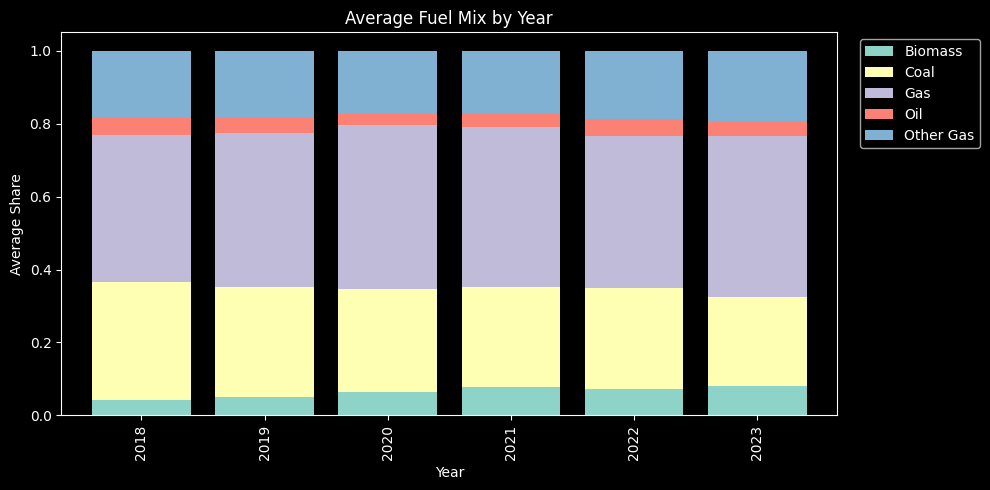


Sample Facility Time Series


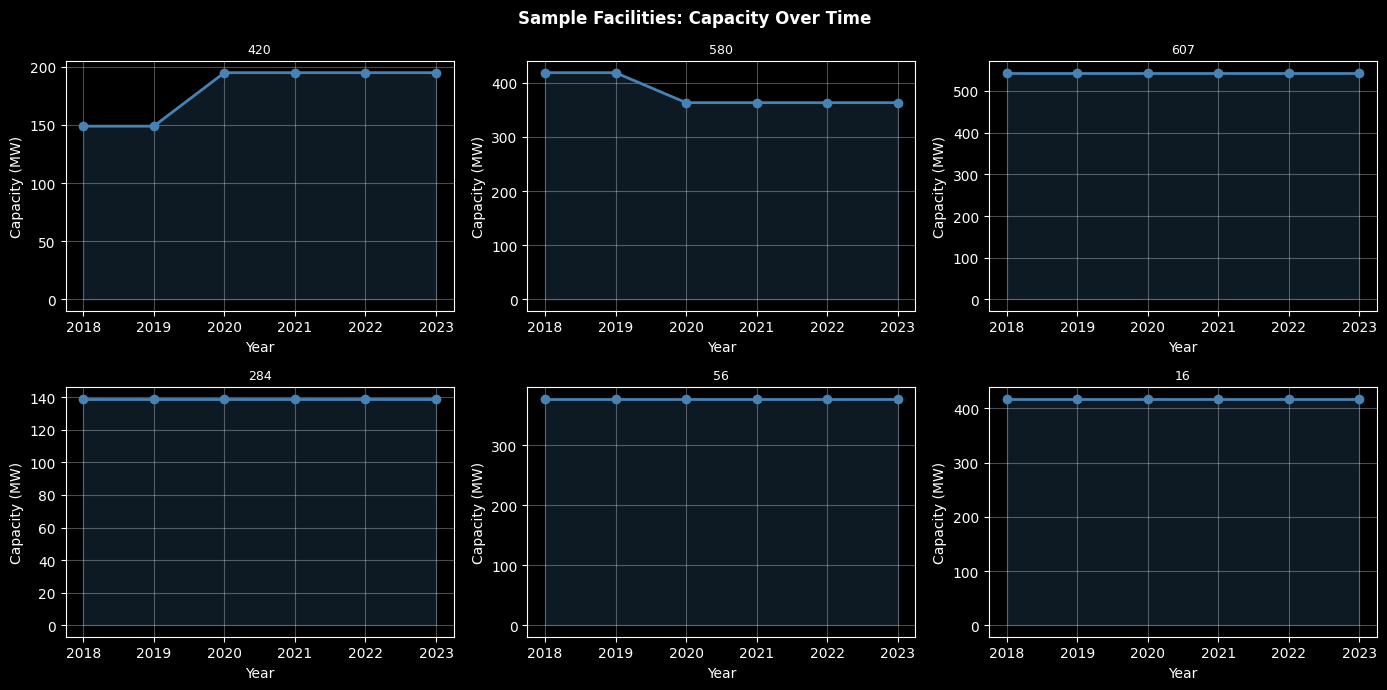

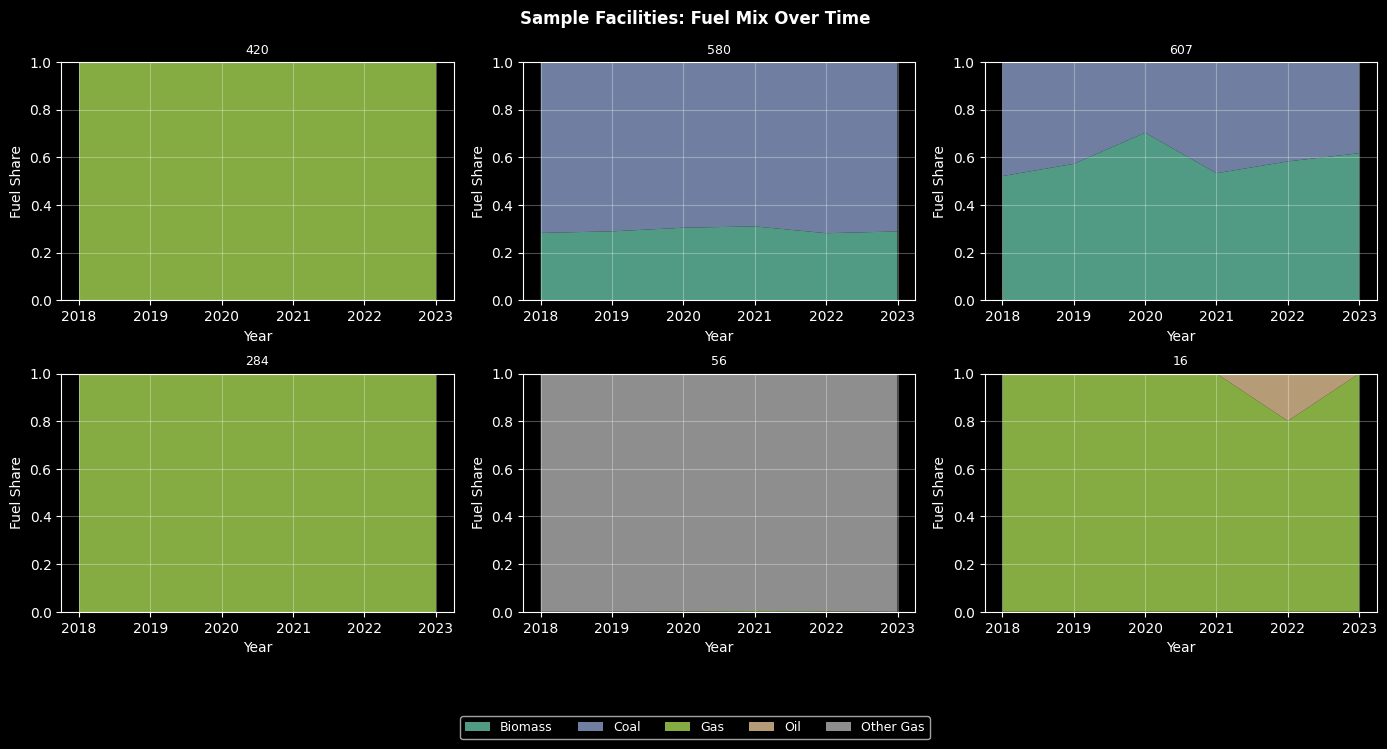

,country_code,n,share
9,PL,81,0.360000
4,FR,54,0.240000
0,AT,24,0.106667
3,ES,22,0.097778
11,SE,17,0.075556
5,HR,7,0.031111
2,EL,5,0.022222
1,EE,4,0.017778
8,LT,4,0.017778
10,PT,4,0.017778


In [ ]:
from eda import fac_eda

facilities_static = pd.read_parquet("out/facilities_static.parquet")
facilities_yearly = pd.read_parquet("out/facilities_yearly.parquet")
fac_eda(facilities_static, facilities_yearly, fac_id_col=FAC_ID_COL)

### 4.2 Time Varying ETS Stringency Data


1. Summary Statistics:


,eu_verified_tco2,eu_alloc_total_tco2,eu_shortfall_tco2,eu_alloc_ratio
count,1274.00,1274.00,1274.00,1274.00
mean,697339.84,340656.77,356683.06,0.59
std,1140243.98,782627.56,663543.63,1.09
min,503.00,1313.00,-614838.00,0.01
25%,144996.25,33830.50,54862.50,0.12
50%,285718.00,87578.50,163583.00,0.39
75%,759822.75,309641.00,442533.00,0.74
max,9399356.00,6864172.00,8090008.00,19.57


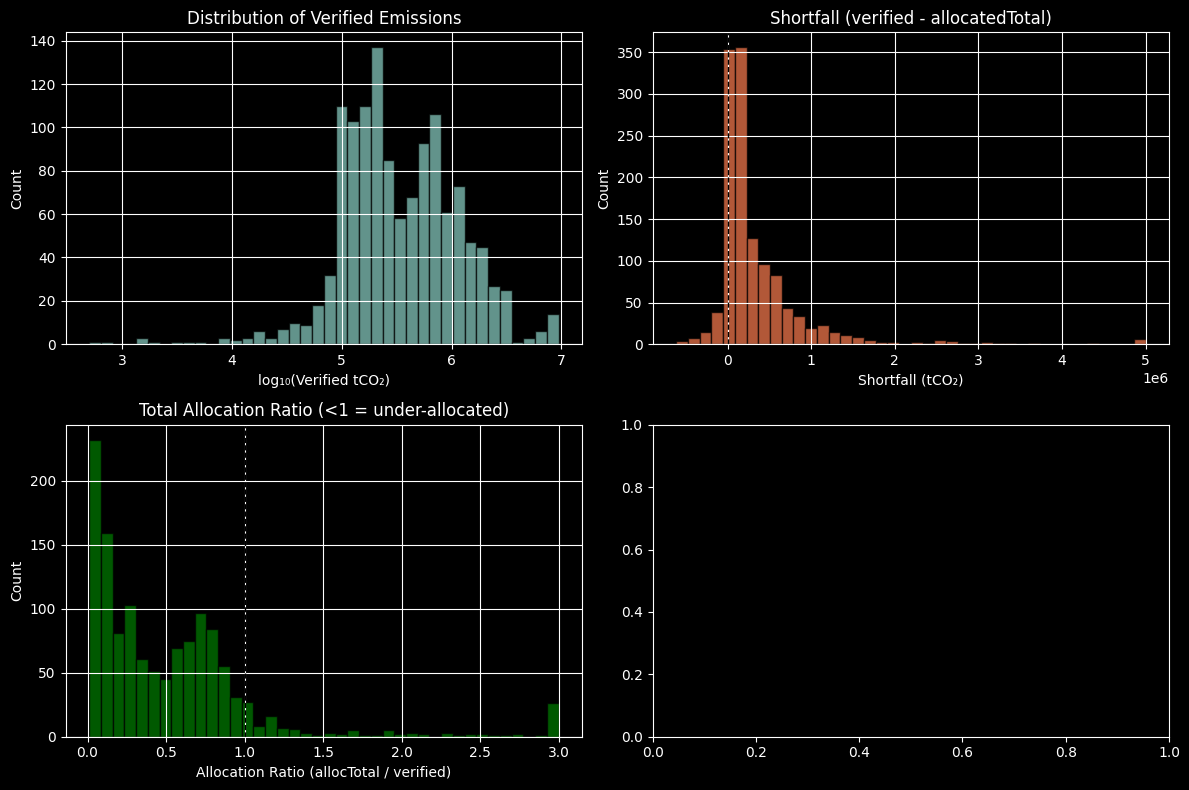


2. Time Series for Sample Plants (allocatedTotal):


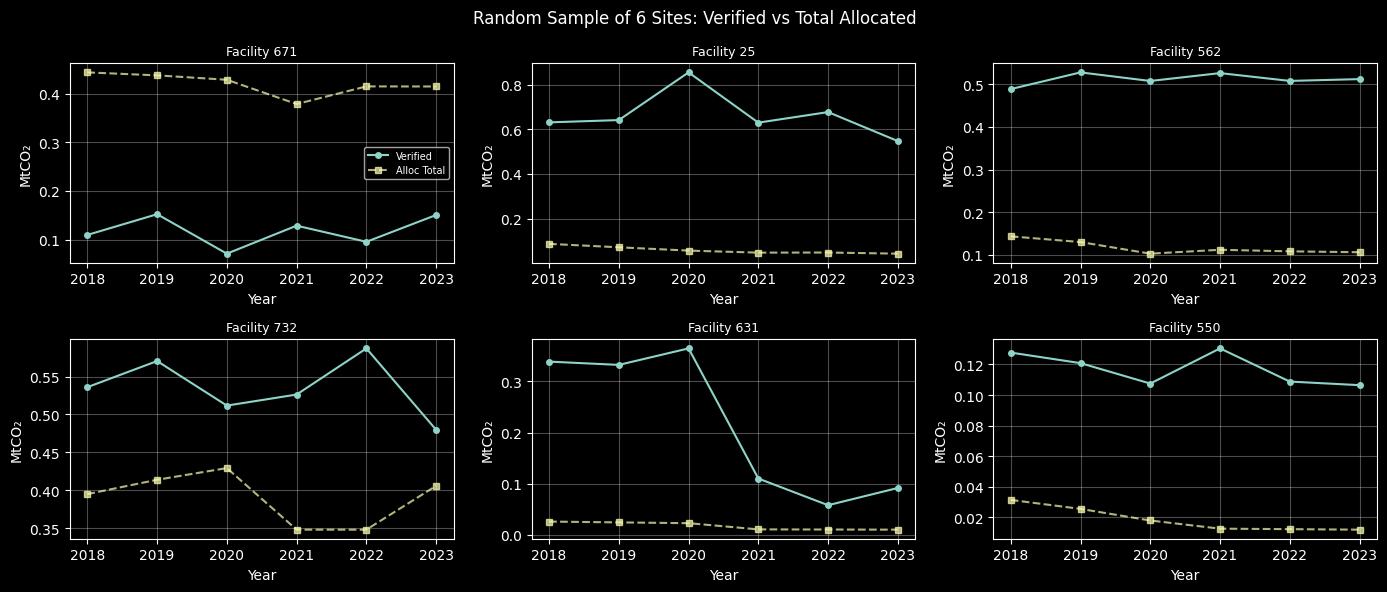


3. Aggregate Trends:


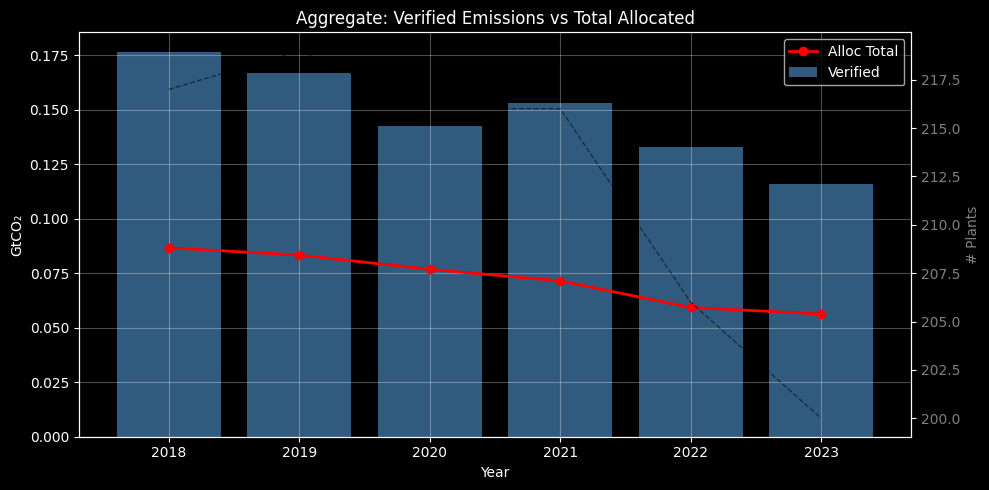

In [ ]:
from eda import ets_eda

ets_eda(facilities_yearly, fac_id_col=FAC_ID_COL)

## 5. TROPOMI NO₂ Beirle-style NOx Emission Outcome (Flux Divergence)

### Goal
Estimate yearly NOx emissions from each facility using the **Beirle-style flux divergence (advection) method**. This approach quantifies emissions by computing the spatial integral of the wind-driven advection of NO₂ concentrations, then applying a lifetime correction.

### Data
- **TROPOMI (Sentinel-5P) L3:** NO₂ daily overpasses. **Data available from 2018**. Dataset: [NO₂](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S5P_OFFL_L3_NO2).
- **Winds (ERA5-Land Hourly):** Daily mean u10/v10 for wind fields. Resolution ~11 km. Dataset: [ECMWF/ERA5_LAND/HOURLY](https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_LAND_HOURLY).

### Method: Beirle Flux Divergence (Advection)

Following **Beirle et al. (2023)**, ESSD 15, 3051–3073:

1. **For each day with valid TROPOMI data:**
   - Compute horizontal gradient ∇V of NOx TVCD (mol/m²) at each pixel
   - Compute advection: $A = \mathbf{w} \cdot \nabla V$ (scalar product of wind and gradient)
   - "The advection is calculated as the scalar product of the wind vector and the gradient of the TVCD... The resulting scalar A is independent from the coordinate system." (Sect. 3.5-3.6)

2. **Temporal averaging:**
   - Aggregate daily advection maps to yearly means (pixelwise)
   - Compute standard error of the mean for uncertainty quantification

3. **Spatial integration:**
   - Integrate mean advection within 15 km radius around facility
   - "We have simplified the calculation of emissions by just integrating the advection map spatially 15 km around the point source location." (Sect. 3.10.1)

4. **Lifetime correction:**
   - Apply correction factor $c_τ = 1/(1 - e^{-t_r/τ})$ where $t_r = R/|w|$ is residence time
   - τ from Lange et al. (2022): $τ = 1.90 + 0.027 × |lat|$ hours
   - "The lifetime correction has to compensate for the integrated loss within the residence time" (Sect. 3.10.2)

5. **NO₂ → NOx scaling:**
   - Using photostationary state: NOx/NO₂ ≈ 1.38 ± 0.10 for mid-latitudes (Sect. 3.4)

### Key Parameters (from Beirle v2)
| Parameter | Value | Source |
|-----------|-------|--------|
| Integration radius | 15 km | Sect. 3.10.1 |
| Plume height | 500 m above ground | Sect. 3.12.3 |
| Min wind speed | 2 m/s | Sect. 3.5 |
| Detection limit (generic) | 0.11 kg/s | Sect. 3.11.1 |
| Detection limit (ideal) | 0.03 kg/s | Sect. 3.11.1 |

### Uncertainty Components
Following Beirle et al. (2023) Sect. 3.12:
- **Statistical error**: Standard error of temporal mean, propagated through spatial integration
- **Lifetime correction**: 50% relative uncertainty (Sect. 3.12.1)
- **OFFL vs PAL product**: ±25% (from 10-40% TVCD difference noted in Sect. 5.3.7)
- **NOx/NO₂ scaling**: ~10% (Sect. 3.4)

### References
- **Beirle et al. (2023)** — *Improved catalog of NOx point source emissions (version 2)*. ESSD 15, 3051–3073. [doi:10.5194/essd-15-3051-2023](https://doi.org/10.5194/essd-15-3051-2023)
- **Beirle et al. (2021)** — *Pinpointing nitrogen oxide emissions from space*. ESSD 13, 2995–3012. [doi:10.5194/essd-13-2995-2021](https://doi.org/10.5194/essd-13-2995-2021)
- **Lange et al. (2022)** — NOx lifetime parameterization by latitude
- **Dickerson et al. (1982)** — NO₂ photolysis rate parameterization

### References — Beirle NOx Outcome

**Core methodology:**
- Beirle et al. (2023) — *Improved catalog of NOx point source emissions (version 2)*. ESSD 15, 3051–3073. [doi:10.5194/essd-15-3051-2023](https://doi.org/10.5194/essd-15-3051-2023)
- Beirle et al. (2021) — *Pinpointing nitrogen oxide emissions from space*. ESSD 13, 2995–3012. [doi:10.5194/essd-13-2995-2021](https://doi.org/10.5194/essd-13-2995-2021)

**Lifetime parameterization:**
- Lange et al. (2022) — *NOx lifetime and emissions from cities and power plants worldwide*. (provides τ = 1.90 + 0.027 × |lat|)

**NO₂ photolysis / NOx scaling:**
- Dickerson et al. (1982) — J_NO2 parameterization by solar zenith angle
- IUPAC (2013) — Rate constant k for NO + O₃ reaction

**Technical documentation & data products:**
- Sentinel-5P OFFL L3 NO₂ – Google Earth Engine. [developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S5P_OFFL_L3_NO2](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S5P_OFFL_L3_NO2)
- ERA5-Land Hourly – Google Earth Engine. [developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_LAND_HOURLY](https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_LAND_HOURLY)

### Load Data and Initialize Earth Engine

In [ ]:
# =============================================================================
# Initialize Earth Engine and load facility data
# =============================================================================
import ee  # type: ignore
import time

try:
    ee.Initialize()
except Exception:
    ee.Authenticate()
    ee.Initialize()

# Load facility data
facilities_static = pd.read_parquet("out/facilities_static.parquet")
facilities_yearly = pd.read_parquet("out/facilities_yearly.parquet")

print(f"Loaded: {len(facilities_static):,} facilities, {len(facilities_yearly):,} facility-years")
print(f"Years in panel: {sorted(facilities_yearly['year'].unique())}")
print("Earth Engine initialized.")

Loaded: 225 facilities, 1,274 facility-years
Years in panel: [np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023)]
Earth Engine initialized.
Cone geometry: ±30°, 0–30 km
Calm threshold: 0.5 m/s | Max retries: 3


### Visualize Beirle Method for a Sample Facility (Optional)

This visualization is for diagnostic purposes only. The actual processing is done via `build_beirle_panel()`.

In [ ]:
# =============================================================================
# (Optional) Visualize advection for a sample large emitter
# =============================================================================
# This is for diagnostic purposes. Uncomment and run to visualize:
# from beirle_outcome import plot_advection_map
# m = plot_advection_map(lon=21.3363, lat=50.4368, year=2022, month=6)
# m  # Display map

print("Visualization cell - uncomment code above to visualize a sample facility.")

Found 52 facilities with ≥1 MtCO2 verified emissions in 2018
Top 5 emitters:


,idx,eu_verified_tco2,capacity_mw
1020,617,8219329.0,4675.9
64,18,7816077.0,1062.0
30,8,7816077.0,203.0
159,59,7758535.0,4400.0
574,361,7460796.0,620.0



Selected: Facility 617 | ['"ENEA Elektrownia Połaniec Spółka Akcyjna - O-001372-0001/16"', '"ENEA Elektrownia Połaniec Spółka Akcyjna - O-001372-0002/16"']
Location: (50.437, 21.336) | Country: PL
Verified emissions: 8.22 MtCO2/yr
Cone params: 0–30 km, ±30° half-angle
Days in 2018: 365 total, 6 calm (<0.5 m/s), 359 usable

Searching for a day with valid NO2 data...
Found valid data on day 29: 2018-06-29

Selected day: 2018-06-29
Wind: 4.1 m/s from 78° (direction wind comes FROM)
Downwind cone bearing: 258° (direction plume travels)
Upwind cone bearing: 78° (background direction)

=== NO2 Values for this day ===
Downwind mean: 29.72 μmol/m²
Upwind mean:   32.84 μmol/m²
Delta (dw-up): -3.11 μmol/m²
⚠ Negative enhancement - upwind has higher NO2 (unexpected for large emitter)


Map(center=[50.43675, 21.3363], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topr…

### Build Facility × Year Beirle NOx Panel

Build the Beirle-style NOx emission panel using the `data.beirle_outcome` module. The output includes for each facility-year:
- `beirle_nox_kg_s`: Estimated NOx emission rate (kg/s)
- `beirle_nox_t_yr`: Annual NOx emissions (tonnes/year)
- `c_tau`: Lifetime correction factor
- `n_days_satellite`: Number of valid satellite days
- Uncertainty estimates (statistical, lifetime, product)

In [ ]:
# =============================================================================
# Build Beirle-style NOx emission panel
# =============================================================================
from beirle_outcome import build_beirle_panel, load_beirle_panel

os.makedirs("out", exist_ok=True)

# Get years from the facilities panel
years = sorted(facilities_yearly['year'].unique())
print(f"Building Beirle panel for years: {years}")

# Build the panel (with caching and resumption)
beirle_panel = build_beirle_panel(
    facilities_static=facilities_static,
    years=years,
    fac_id_col=FAC_ID_COL,
    cache_dir='out',
    resume=True
)

# Save combined panel
if not beirle_panel.empty:
    beirle_panel.to_parquet("out/beirle_panel.parquet", index=False)
    print(f"\n✓ Saved Beirle panel: {len(beirle_panel):,} facility-years")
    print(f"  Columns: {list(beirle_panel.columns)}")
else:
    print("Warning: No Beirle panel data generated")

Processing 1274 facility-years from panel
[2018] 217 facility-years expected...
  Resuming: 204 valid, 13 failed (no NO2), 217/217 total done
  All 217 facilities already processed for 2018
[2018] Done: 204/217 valid rows
[2019] 219 facility-years expected...
  Resuming: 56 valid, 4 failed (no NO2), 60/219 total done


year=2019:  27%|##7       | 60/219 [00:00<?, ?it/s]

  fac 70/219: 360 days, NO₂Δ=-8.82e-07
  [checkpoint] 65 valid, 5 failed saved


In [ ]:
# =============================================================================
# Diagnostic: Beirle NOx Emission Distribution
# =============================================================================
# Load first year's data to examine distribution

beirle_2018_path = "out/beirle_2018.parquet"
if os.path.exists(beirle_2018_path):
    bp_2018 = pd.read_parquet(beirle_2018_path)
    print(f"Loaded {len(bp_2018):,} facility-years from 2018 Beirle data")
    print(f"Columns: {list(bp_2018.columns)}")

    # Key statistics
    print("\n=== Beirle NOx Emissions (kg/s) ===")
    print(f"Mean:   {bp_2018['beirle_nox_kg_s'].mean():.4f}")
    print(f"Median: {bp_2018['beirle_nox_kg_s'].median():.4f}")
    print(f"Std:    {bp_2018['beirle_nox_kg_s'].std():.4f}")
    print(f"Min:    {bp_2018['beirle_nox_kg_s'].min():.4f}")
    print(f"Max:    {bp_2018['beirle_nox_kg_s'].max():.4f}")

    # Above detection limit
    above_dl = bp_2018['above_DL_generic'].sum() if 'above_DL_generic' in bp_2018.columns else 'N/A'
    print(f"\nAbove generic detection limit (0.11 kg/s): {above_dl}")

    # Distribution plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Histogram
    ax = axes[0]
    ax.hist(bp_2018['beirle_nox_kg_s'].dropna(), bins=50, edgecolor='black', alpha=0.7)
    ax.axvline(0.11, color='red', linestyle='--', linewidth=2, label='Detection limit (0.11 kg/s)')
    ax.axvline(bp_2018['beirle_nox_kg_s'].mean(), color='green', linestyle='-', linewidth=2, 
               label=f'Mean = {bp_2018["beirle_nox_kg_s"].mean():.3f}')
    ax.set_xlabel('NOx Emission (kg/s)')
    ax.set_ylabel('Count')
    ax.set_title('Distribution of Beirle NOx Emissions (2018)')
    ax.legend()

    # Lifetime correction factor
    ax = axes[1]
    if 'c_tau' in bp_2018.columns:
        ax.hist(bp_2018['c_tau'].dropna(), bins=30, edgecolor='black', alpha=0.7, color='orange')
        ax.set_xlabel('Lifetime Correction Factor (c_τ)')
        ax.set_ylabel('Count')
        ax.set_title('Distribution of c_τ (expected ~1.2-1.8)')
        ax.axvline(bp_2018['c_tau'].mean(), color='green', linestyle='-', linewidth=2,
                   label=f'Mean = {bp_2018["c_tau"].mean():.2f}')
        ax.legend()

    plt.tight_layout()
    plt.show()
else:
    print(f"No Beirle data at {beirle_2018_path} - run the panel build cell first")

### Merge Beirle NOx emission data into facilities_yearly

Note: The Beirle panel is saved separately as `out/beirle_panel.parquet` and can be merged downstream for analysis. Here we merge key meteorological data (wind speed, satellite days) into the main panel.

In [ ]:
# =============================================================================
# Merge Beirle panel meteorological data into facilities_yearly
# =============================================================================

# Load Beirle panel (if it exists)
beirle_path = "out/beirle_panel.parquet"
if os.path.exists(beirle_path):
    beirle_panel = pd.read_parquet(beirle_path)
    
    # Columns to add from Beirle panel
    merge_cols = ['mean_ws_ms', 'n_days_satellite']
    available_cols = [c for c in merge_cols if c in beirle_panel.columns]
    
    if available_cols:
        # Check coverage before merge
        required_pairs = set(zip(facilities_yearly[FAC_ID_COL], facilities_yearly["year"]))
        available_pairs = set(zip(beirle_panel[FAC_ID_COL], beirle_panel["year"]))
        missing_pairs = required_pairs - available_pairs
        
        print(f"Required facility-years: {len(required_pairs):,}")
        print(f"Available in Beirle panel: {len(available_pairs):,}")
        print(f"Missing: {len(missing_pairs):,}")
        
        # Left merge to keep all facility-years
        n_before = len(facilities_yearly)
        facilities_yearly = facilities_yearly.merge(
            beirle_panel[[FAC_ID_COL, "year"] + available_cols],
            on=[FAC_ID_COL, "year"],
            how="left"
        )
        print(f"\nAfter merge: {n_before:,} → {len(facilities_yearly):,} facility-years")
        print(f"Added columns: {available_cols}")
else:
    print(f"Beirle panel not found at {beirle_path} - run the panel build cell first")
    print("Proceeding without satellite meteorology data")

# Save updated parquets
facilities_yearly.to_parquet("out/facilities_yearly.parquet", index=False)
facilities_static.to_parquet("out/facilities_static.parquet", index=False)

print(f"\n✓ Saved aligned panels:")
print(f"  facilities_yearly: {len(facilities_yearly):,} rows, {facilities_yearly[FAC_ID_COL].nunique():,} facilities")
print(f"  facilities_static: {len(facilities_static):,} rows")
print(f"  Columns: {list(facilities_yearly.columns)}")

NameError: name 'windcone_panel' is not defined

## 6. NOx Emission Outcome - EDA

Exploratory analysis of the Beirle-style NOx emission estimates.

In [ ]:
def beirle_eda(beirle_panel: DataFrame, static_panel: DataFrame):
    """
    EDA for Beirle-style NOx emission estimates.
    
    Key variables:
    - beirle_nox_kg_s: NOx emission rate (kg/s)
    - beirle_nox_t_yr: Annual NOx emissions (tonnes/year)
    - c_tau: Lifetime correction factor
    - rel_err_total: Total relative uncertainty
    """
    if beirle_panel.empty:
        print("No Beirle panel data available")
        return
        
    df = beirle_panel.copy()
    
    # Merge country for grouping
    df = df.merge(static_panel[[FAC_ID_COL, 'country_code']], on=FAC_ID_COL, how='left')
    
    print("="*60)
    print("BEIRLE NOx EMISSION EDA")
    print("="*60)
    print(f"Facility-years: {len(df):,} | Facilities: {df[FAC_ID_COL].nunique():,}")
    print(f"Years: {int(df['year'].min())}–{int(df['year'].max())}")
    
    # -------------------------------------------------------------------------
    # 1. Summary Statistics
    # -------------------------------------------------------------------------
    print("\n" + "-"*40)
    print("1. Summary Statistics")
    print("-"*40)
    
    emission_cols = ['beirle_nox_kg_s', 'beirle_nox_t_yr', 'c_tau', 'mean_ws_ms', 'n_days_satellite']
    avail_cols = [c for c in emission_cols if c in df.columns]
    
    if avail_cols:
        stats = df[avail_cols].describe().T
        stats['non_null'] = df[avail_cols].notna().sum()
        display(stats.round(4))
    
    # -------------------------------------------------------------------------
    # 2. Distribution of Emissions
    # -------------------------------------------------------------------------
    print("\n" + "-"*40)
    print("2. Distribution of NOx Emissions")
    print("-"*40)
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # NOx emission rate (kg/s)
    ax = axes[0, 0]
    if 'beirle_nox_kg_s' in df.columns:
        data = df['beirle_nox_kg_s'].dropna()
        ax.hist(data, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
        ax.axvline(0.11, color='red', linestyle='--', linewidth=2, label='DL = 0.11 kg/s')
        ax.axvline(data.mean(), color='green', linestyle='-', linewidth=2, 
                   label=f'Mean = {data.mean():.3f}')
        ax.set_xlabel('NOx Emission (kg/s)')
        ax.set_ylabel('Frequency')
        ax.set_title('NOx Emission Rate Distribution')
        ax.legend()
    
    # Annual emissions (tonnes/yr)
    ax = axes[0, 1]
    if 'beirle_nox_t_yr' in df.columns:
        data = df['beirle_nox_t_yr'].dropna()
        ax.hist(data, bins=50, color='coral', edgecolor='black', alpha=0.7)
        ax.axvline(data.mean(), color='green', linestyle='-', linewidth=2,
                   label=f'Mean = {data.mean():.0f}')
        ax.set_xlabel('NOx Emission (tonnes/yr)')
        ax.set_ylabel('Frequency')
        ax.set_title('Annual NOx Emission Distribution')
        ax.legend()
    
    # Lifetime correction factor
    ax = axes[1, 0]
    if 'c_tau' in df.columns:
        data = df['c_tau'].dropna()
        ax.hist(data, bins=30, color='orange', edgecolor='black', alpha=0.7)
        ax.axvline(data.mean(), color='green', linestyle='-', linewidth=2,
                   label=f'Mean = {data.mean():.2f}')
        ax.set_xlabel('Lifetime Correction (c_τ)')
        ax.set_ylabel('Frequency')
        ax.set_title('Lifetime Correction Factor (expected 1.2-1.8)')
        ax.legend()
    
    # Relative uncertainty
    ax = axes[1, 1]
    if 'rel_err_total' in df.columns:
        data = df['rel_err_total'].dropna() * 100  # Convert to %
        ax.hist(data, bins=30, color='purple', edgecolor='black', alpha=0.7)
        ax.axvline(data.mean(), color='green', linestyle='-', linewidth=2,
                   label=f'Mean = {data.mean():.1f}%')
        ax.set_xlabel('Total Relative Uncertainty (%)')
        ax.set_ylabel('Frequency')
        ax.set_title('Uncertainty Distribution (expected 20-40%)')
        ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    # -------------------------------------------------------------------------
    # 3. Above Detection Limit
    # -------------------------------------------------------------------------
    print("\n" + "-"*40)
    print("3. Detection Limit Analysis")
    print("-"*40)
    
    if 'above_DL_generic' in df.columns:
        above_dl = df['above_DL_generic'].sum()
        pct_above = 100 * above_dl / len(df)
        print(f"Above generic DL (0.11 kg/s): {above_dl:,} ({pct_above:.1f}%)")
    
    if 'above_DL_ideal' in df.columns:
        above_dl = df['above_DL_ideal'].sum()
        pct_above = 100 * above_dl / len(df)
        print(f"Above ideal DL (0.03 kg/s): {above_dl:,} ({pct_above:.1f}%)")
    
    # -------------------------------------------------------------------------
    # 4. By Country
    # -------------------------------------------------------------------------
    print("\n" + "-"*40)
    print("4. Emissions by Country")
    print("-"*40)
    
    if 'beirle_nox_kg_s' in df.columns and 'country_code' in df.columns:
        country_stats = df.groupby('country_code').agg({
            'beirle_nox_kg_s': ['mean', 'std', 'count'],
            FAC_ID_COL: 'nunique'
        }).round(4)
        country_stats.columns = ['mean_kg_s', 'std_kg_s', 'n_fac_years', 'n_facilities']
        display(country_stats.sort_values('mean_kg_s', ascending=False))

# Load and run EDA
beirle_path = "out/beirle_panel.parquet"
if os.path.exists(beirle_path):
    beirle_panel_eda = pd.read_parquet(beirle_path)
    beirle_eda(beirle_panel_eda, facilities_static)
else:
    print(f"Beirle panel not found at {beirle_path}")

POLLUTION OUTCOME EDA (Windcones)
Facility-years: 1,274 | Facilities: 225
Years: 2018–2023

----------------------------------------
1. Summary Statistics (mol/m²)
----------------------------------------


ValueError: Cannot describe a DataFrame without columns

## 7. AlphaEarth Geographic Embeddings

Download **Google AlphaEarth Satellite Embeddings** for each facility to capture geographic context as high-dimensional features.

### AlphaEarth Overview
- **Source**: `GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL` (Earth Engine)
- **Paper**: [arXiv:2507.22291](https://arxiv.org/abs/2507.22291)
- **Native resolution**: 4m per pixel
- **Dimensions**: 64 embedding dimensions (bands A00–A63)

### Sampling Strategy
- **10km scale**: Each facility gets the mean embedding of its 10km × 10km grid cell
- **Yearly composites**: Temporal variation captured across years
- Matches the 0–10km inner portion of the pollution near ring

### Use Case
The embeddings capture high-dimensional learned features from satellite imagery that correlate with:
- Land use patterns (urban density, industrial clustering)
- Vegetation and terrain
- Infrastructure and built environment
- Climate and weather patterns

These 64-dimensional embeddings provide a compact representation of the geographic context around each facility, useful for controlling for spatial heterogeneity between plants.

In [ ]:
try:
    ee.Initialize()
except Exception:
    ee.Authenticate()
    ee.Initialize()

emb_ic = ee.ImageCollection("GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL")
SCALE_EMB = 10_000  # 10km - EE averages the cell automatically

# Get the facility-years from the final panel
facilities_yearly = pd.read_parquet("out/facilities_yearly.parquet")
facilities_static = pd.read_parquet("out/facilities_static.parquet")
final_fac_ids = set(facilities_yearly[FAC_ID_COL].unique())

# Ensure static rows that are not in the final panel are dropped
facilities_static = facilities_static[facilities_static[FAC_ID_COL].isin(final_fac_ids)].copy()

print(f"AlphaEarth: Sampling at {SCALE_EMB/1000:.0f}km scale (64 dimensions)")

# Debug: Test one European facility
euro_facs = facilities_static[
    (facilities_static["lat"] > 40) & (facilities_static["lat"] < 60) &
    (facilities_static["lon"] > -10) & (facilities_static["lon"] < 30)
]
test_fac = euro_facs.iloc[0] if len(euro_facs) > 0 else facilities_static.iloc[0]
print(f"Debug: Testing facility {test_fac[FAC_ID_COL]} at ({test_fac['lat']:.2f}, {test_fac['lon']:.2f})")

# Test with simplified approach: point + scale
test_pt = ee.Geometry.Point([float(test_fac["lon"]), float(test_fac["lat"])])
test_img = (emb_ic
    .filterDate("2022-01-01", "2023-01-01")
    .filterBounds(test_pt)
    .mosaic()
)

test_vals = test_img.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=test_pt,
    scale=SCALE_EMB
).getInfo()

print(f"Test result: A00={test_vals.get('A00'):.4f}, A01={test_vals.get('A01'):.4f}" if test_vals.get('A00') else "Test failed!")

def get_annual_mosaic(y: int, pt):
    """Get mosaicked embedding image for a year, filtered to point location."""
    return (emb_ic
        .filterDate(f"{y}-01-01", f"{y+1}-01-01")
        .filterBounds(pt)
        .mosaic()
    )

def sample_embeddings_for_year(df_fac: DataFrame, fac_ids: set, year: int) -> DataFrame:
    """Sample AlphaEarth embeddings at 10km scale for specified facilities."""
    
    facs_to_sample = df_fac[df_fac[FAC_ID_COL].isin(fac_ids)]
    
    if facs_to_sample.empty:
        return DataFrame()
    
    rows = []
    
    for i, (_, fac) in enumerate(facs_to_sample.iterrows()):
        fac_id = int(fac[FAC_ID_COL])
        lon, lat = float(fac["lon"]), float(fac["lat"])
        
        pt = ee.Geometry.Point([lon, lat])
        img = get_annual_mosaic(year, pt)
        
        # Sample at 10km scale - EE returns the cell average
        vals = img.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=pt,
            scale=SCALE_EMB
        ).getInfo()
        
        if vals and any(v is not None for v in vals.values()):
            vals[FAC_ID_COL] = fac_id
            vals["year"] = year
            rows.append(vals)
        elif i == 0:
            print(f"    [{year}] First facility {fac_id} at ({lat:.2f}, {lon:.2f}): no data")
        
        if (i + 1) % 50 == 0:
            print(f"    [{year}] Processed {i+1}/{len(facs_to_sample)} facilities, {len(rows)} valid...")
    
    if not rows:
        return DataFrame()
    
    out = DataFrame(rows)
    rename_map = {f"A{i:02d}": f"emb_{i:02d}" for i in range(64)}
    out = out.rename(columns=rename_map)
    
    return out

# =============================================================================
# Download with yearly caching
# =============================================================================

os.makedirs("out", exist_ok=True)
fac_years_by_year = facilities_yearly.groupby("year")[FAC_ID_COL].apply(set).to_dict()

print(f"\nDownloading embeddings for {len(facilities_yearly):,} facility-years")
print(f"Years: {sorted(fac_years_by_year.keys())}")

all_emb_dfs = []

for year in sorted(fac_years_by_year.keys()):
    year = int(year)
    fac_ids_for_year = fac_years_by_year[year]
    cache_path = f"out/emb_{year}.parquet"
    
    cached_df = None
    cached_facs = set()
    
    if os.path.exists(cache_path):
        try:
            cached_df = pd.read_parquet(cache_path)
            if 'emb_00' in cached_df.columns and cached_df['emb_00'].notna().any():
                cached_facs = set(cached_df[cached_df['emb_00'].notna()][FAC_ID_COL].unique())
            else:
                print(f"[{year}] Cache exists but has no valid embeddings, re-downloading...")
                cached_df = None
        except Exception as e:
            print(f"[{year}] Error reading cache: {e}")
            cached_df = None
    
    missing_facs = fac_ids_for_year - cached_facs
    
    if not missing_facs:
        print(f"[{year}] Using cached data ({len(cached_df):,} rows)")  
        all_emb_dfs.append(cached_df[cached_df[FAC_ID_COL].isin(fac_ids_for_year)])  
        continue
    
    if cached_facs:
        print(f"[{year}] Cache has {len(cached_facs):,} facilities, downloading {len(missing_facs):,} missing...")
    else:
        print(f"[{year}] No cache, downloading {len(missing_facs):,} facilities...")
    
    df_new = sample_embeddings_for_year(facilities_static, missing_facs, year)
    
    if df_new.empty and not cached_facs:
        print(f"[{year}] WARNING: No data downloaded and no cache!")
        continue
    
    if cached_df is not None and not cached_df.empty:
        cached_keep = cached_df[(cached_df[FAC_ID_COL].isin(fac_ids_for_year)) & (cached_df['emb_00'].notna())]
        if not df_new.empty:
            df_year = pd.concat([cached_keep, df_new], ignore_index=True)
        else:
            df_year = cached_keep
    else:
        df_year = df_new
    
    if not df_year.empty:
        df_year.to_parquet(cache_path, index=False)
        all_emb_dfs.append(df_year)
        n_valid = df_year['emb_00'].notna().sum() if 'emb_00' in df_year.columns else 0
        print(f"[{year}] Saved {len(df_year):,} rows ({n_valid} valid) to {cache_path}")
    else:
        print(f"[{year}] No data to save!")

if all_emb_dfs:
    emb_panel = pd.concat(all_emb_dfs, ignore_index=True)
    emb_cols = [c for c in emb_panel.columns if c.startswith("emb_")]
    n_valid = emb_panel['emb_00'].notna().sum() if 'emb_00' in emb_panel.columns else 0
    print(f"\n✓ Combined embedding panel: {len(emb_panel):,} rows, {emb_panel[FAC_ID_COL].nunique():,} facilities, {len(emb_cols)} dimensions")
    print(f"  Valid embeddings: {n_valid:,} ({100*n_valid/len(emb_panel):.1f}%)")
else:
    emb_panel = DataFrame()
    print("No embedding data available!")

AlphaEarth: Sampling at 10km scale (64 dimensions)
Debug: Testing facility 130 at (40.68, 22.88)
Test result: A00=-0.0178, A01=-0.3014

Years: [2018, 2019, 2020, 2021, 2022, 2023]
[2018] Cache has 254 facilities, downloading 14 missing...
    [2018] First facility 327 at (47.34, 16.02): no data
[2018] Saved 254 rows (254 valid) to data/out/emb_2018.parquet
[2019] Cache has 264 facilities, downloading 14 missing...
    [2019] First facility 327 at (47.34, 16.02): no data
[2019] Saved 264 rows (264 valid) to data/out/emb_2019.parquet
[2020] Cache has 260 facilities, downloading 14 missing...
    [2020] First facility 327 at (47.34, 16.02): no data
[2020] Saved 260 rows (260 valid) to data/out/emb_2020.parquet
[2021] Cache has 261 facilities, downloading 14 missing...
    [2021] First facility 327 at (47.34, 16.02): no data
[2021] Saved 261 rows (261 valid) to data/out/emb_2021.parquet
[2022] Cache has 240 facilities, downloading 13 missing...
    [2022] First facility 327 at (47.34, 16.0

In [21]:
emb_panel.head()

,emb_00,emb_01,emb_02,emb_03,emb_04,emb_05,emb_06,emb_07,emb_08,emb_09,...,emb_56,emb_57,emb_58,emb_59,emb_60,emb_61,emb_62,emb_63,idx,year
0,-0.071111,-0.108512,-0.192910,-0.160000,-0.066990,0.000984,0.119093,0.135886,0.022207,0.088827,...,-0.003014,0.035433,0.012057,0.003014,0.141730,-0.199862,0.041584,0.160000,4,2018
1,0.055363,-0.259900,-0.051734,0.044844,-0.015748,-0.001538,0.147697,0.160000,0.032541,0.003937,...,0.006151,0.051734,-0.062991,-0.007443,0.141730,-0.228897,0.071111,0.172795,37,2018
2,0.022207,-0.192910,-0.088827,0.003014,-0.029773,0.035433,0.113741,0.179377,-0.027128,0.071111,...,-0.059116,0.098424,-0.027128,-0.022207,0.088827,-0.236463,0.084214,0.236463,49,2018
3,0.022207,-0.192910,-0.088827,0.003014,-0.029773,0.035433,0.113741,0.179377,-0.027128,0.071111,...,-0.059116,0.098424,-0.027128,-0.022207,0.088827,-0.236463,0.084214,0.236463,51,2018
4,0.135886,-0.108512,0.017778,0.071111,0.071111,0.088827,0.051734,0.141730,0.084214,-0.007443,...,0.055363,0.075356,-0.088827,-0.075356,0.206936,-0.160000,-0.015748,-0.035433,64,2018


In [ ]:
# =============================================================================
# Merge embeddings into facilities_yearly
# =============================================================================

# Identify embedding columns (everything except idx and year)
emb_cols = [c for c in emb_panel.columns if c not in [FAC_ID_COL, "year"]]
print(f"Embedding dimensions: {len(emb_cols)}")
if emb_cols:
    print(f"Sample columns: {emb_cols[:5]}...")

# Check coverage before merge
required_pairs = set(zip(facilities_yearly[FAC_ID_COL], facilities_yearly["year"]))
available_pairs = set(zip(emb_panel[FAC_ID_COL], emb_panel["year"])) if not emb_panel.empty else set()
missing_pairs = required_pairs - available_pairs

print(f"Required facility-years: {len(required_pairs):,}")
print(f"Available in embedding panel: {len(available_pairs):,}")
print(f"Missing: {len(missing_pairs):,}")

# Merge embeddings (inner join to keep only rows with embeddings)
n_before = len(facilities_yearly)
facilities_yearly = facilities_yearly.merge(
    emb_panel,
    on=[FAC_ID_COL, "year"],
    how="inner"
)
print(f"\nAfter inner merge: {n_before:,} → {len(facilities_yearly):,} facility-years")

# Filter to facility-years with valid embeddings (if we have embedding columns)
if emb_cols:
    n_before_filter = len(facilities_yearly)
    facilities_yearly = facilities_yearly.dropna(subset=[emb_cols[0]])
    print(f"After embedding filter: {n_before_filter:,} → {len(facilities_yearly):,} facility-years")

# Apply MIN_YEARS filter again (some facilities may now have < MIN_YEARS)
years_per_fac = facilities_yearly.groupby(FAC_ID_COL)["year"].nunique()
facs_enough_years = set(years_per_fac[years_per_fac >= MIN_YEARS].index)

n_before_minyears = len(facilities_yearly)
facilities_yearly = facilities_yearly[facilities_yearly[FAC_ID_COL].isin(facs_enough_years)]
facilities_static = facilities_static[facilities_static[FAC_ID_COL].isin(facs_enough_years)]

print(f"After MIN_YEARS filter: {n_before_minyears:,} → {len(facilities_yearly):,} facility-years")
print(f"Final facilities: {facilities_yearly[FAC_ID_COL].nunique():,}")

# Sanity check alignment
assert set(facilities_yearly[FAC_ID_COL].unique()) == set(facilities_static[FAC_ID_COL].unique()), \
    "Facility ID mismatch between yearly and static!"

# =============================================================================
# Save final panels
# =============================================================================

facilities_yearly.to_parquet("out/facilities_yearly.parquet", index=False)
facilities_static.to_parquet("out/facilities_static.parquet", index=False)

# Summary
print(f"\n" + "="*60)
print("FINAL PANEL SUMMARY")
print("="*60)
print(f"Facilities: {facilities_yearly[FAC_ID_COL].nunique():,}")
print(f"Facility-years: {len(facilities_yearly):,}")
print(f"Years: {int(facilities_yearly['year'].min())}–{int(facilities_yearly['year'].max())}")
print(f"Total columns: {len(facilities_yearly.columns)}")

# Column groups
col_groups = {
    "Keys": [FAC_ID_COL, "year"],
    "Capacity": ["capacity_mw"],
    "Fuel shares": [c for c in facilities_yearly.columns if c.startswith("share_")],
    "ETS exposure": [c for c in facilities_yearly.columns if c.startswith("eu_") or c == "n_installations"],
    "Pollution": ["no2_near", "no2_far", "so2_near", "so2_far", "wind_speed_ms"],
    "Embeddings": emb_cols
}

print("\nColumn groups:")
for group, cols in col_groups.items():
    present = [c for c in cols if c in facilities_yearly.columns]
    print(f"  {group}: {len(present)} columns")

print(f"\n✓ Saved final panels:")
print(f"  out/facilities_yearly.parquet ({len(facilities_yearly):,} rows)")
print(f"  out/facilities_static.parquet ({len(facilities_static):,} rows)")

Embedding dimensions: 64
Sample columns: ['emb_00', 'emb_01', 'emb_02', 'emb_03', 'emb_04']...
Required facility-years: 0
Available in embedding panel: 1,590
Missing: 0

After inner merge: 0 → 0 facility-years


KeyError: ['emb_00']